# Hierarchical Market Regime Classification

This notebook implements a hierarchical approach to market regime classification:
1. Define regimes using longer timeframes (daily/weekly)
2. Apply regime labels to all shorter timeframe periods within those periods
3. This creates more stable, realistic regime classifications

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Starting Hierarchical Regime Classification")

Starting Hierarchical Regime Classification


## 1. Load Data and Create Daily/Weekly Aggregates

In [2]:
# Load 1-minute data
df_1min = pd.read_csv('../data/BTCUSD_2023_1min_cleaned.csv')
df_1min['timestamp'] = pd.to_datetime(df_1min['timestamp'])
df_1min = df_1min.set_index('timestamp').sort_index()

# Clean unnecessary columns
cols_to_drop = [col for col in df_1min.columns if 'Unnamed' in col]
df_1min = df_1min.drop(columns=cols_to_drop)

print(f"1-minute data loaded: {df_1min.shape}")
print(f"Date range: {df_1min.index.min()} to {df_1min.index.max()}")

# Create daily aggregates for regime classification
def create_daily_ohlcv(df_1min):
    """
    Create daily OHLCV data with technical indicators
    """
    daily_agg = df_1min.resample('1D').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min', 
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    # Calculate daily technical indicators
    daily_agg['sma_10'] = daily_agg['Close'].rolling(10).mean()
    daily_agg['sma_20'] = daily_agg['Close'].rolling(20).mean()
    daily_agg['sma_50'] = daily_agg['Close'].rolling(50).mean()
    daily_agg['ema_10'] = daily_agg['Close'].ewm(span=10).mean()
    daily_agg['ema_20'] = daily_agg['Close'].ewm(span=20).mean()
    
    # Daily returns and volatility
    daily_agg['daily_return'] = daily_agg['Close'].pct_change()
    daily_agg['volatility_10d'] = daily_agg['daily_return'].rolling(10).std()
    daily_agg['volatility_20d'] = daily_agg['daily_return'].rolling(20).std()
    
    return daily_agg

# Create weekly aggregates
def create_weekly_ohlcv(df_1min):
    """
    Create weekly OHLCV data with technical indicators
    """
    weekly_agg = df_1min.resample('1W').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    # Calculate weekly technical indicators
    weekly_agg['sma_4'] = weekly_agg['Close'].rolling(4).mean()   # ~1 month
    weekly_agg['sma_8'] = weekly_agg['Close'].rolling(8).mean()   # ~2 months
    weekly_agg['sma_12'] = weekly_agg['Close'].rolling(12).mean() # ~3 months
    weekly_agg['ema_4'] = weekly_agg['Close'].ewm(span=4).mean()
    weekly_agg['ema_8'] = weekly_agg['Close'].ewm(span=8).mean()
    
    # Weekly returns and volatility
    weekly_agg['weekly_return'] = weekly_agg['Close'].pct_change()
    weekly_agg['volatility_4w'] = weekly_agg['weekly_return'].rolling(4).std()
    
    return weekly_agg

# Create aggregated data
df_daily = create_daily_ohlcv(df_1min)
df_weekly = create_weekly_ohlcv(df_1min)

print(f"\nDaily data: {df_daily.shape}")
print(f"Weekly data: {df_weekly.shape}")

# Display first few rows
print("\nDaily data sample:")
print(df_daily[['Open', 'High', 'Low', 'Close', 'sma_20', 'sma_50']].head())

1-minute data loaded: (434438, 25)
Date range: 2023-02-10 00:00:00 to 2023-12-31 14:27:00

Daily data: (325, 13)
Weekly data: (47, 12)

Daily data sample:
               Open     High      Low    Close  sma_20  sma_50
timestamp                                                     
2023-02-10  21759.9  21902.6  21439.7  21563.8     NaN     NaN
2023-02-11  21563.8  21865.4  21540.6  21825.9     NaN     NaN
2023-02-12  21825.8  22048.7  21569.9  21749.6     NaN     NaN
2023-02-13  21750.2  21860.0  21342.3  21754.1     NaN     NaN
2023-02-14  21754.1  22284.7  21525.7  22169.8     NaN     NaN


## 2. Define Regime Classification Methods for Different Timeframes

In [3]:
def classify_daily_regimes(df_daily, method='trend_strength'):
    """
    Classify market regimes using daily data
    """
    df = df_daily.copy()
    
    if method == 'trend_strength':
        # Method 1: Trend strength based on multiple MAs
        # Bull: Price > EMA20 > SMA20 AND SMA20 > SMA50 (strong uptrend)
        bull_condition = (
            (df['Close'] > df['ema_20']) & 
            (df['ema_20'] > df['sma_20']) & 
            (df['sma_20'] > df['sma_50'])
        )
        
        # Bear: Price < EMA20 < SMA20 AND SMA20 < SMA50 (strong downtrend)
        bear_condition = (
            (df['Close'] < df['ema_20']) & 
            (df['ema_20'] < df['sma_20']) & 
            (df['sma_20'] < df['sma_50'])
        )
        
    elif method == 'momentum':
        # Method 2: Momentum-based classification
        returns_5d = df['Close'].pct_change(5)
        returns_10d = df['Close'].pct_change(10)
        
        # Bull: Consistent positive momentum
        bull_condition = (returns_5d > 0.02) & (returns_10d > 0.05)
        
        # Bear: Consistent negative momentum
        bear_condition = (returns_5d < -0.02) & (returns_10d < -0.05)
        
    elif method == 'volatility_adjusted':
        # Method 3: Volatility-adjusted returns
        returns_5d = df['Close'].pct_change(5)
        vol_threshold = df['volatility_10d'].rolling(20).quantile(0.5)  # Median volatility
        
        # Bull: Positive returns with controlled volatility
        bull_condition = (returns_5d > 0.03) & (df['volatility_10d'] < vol_threshold * 1.5)
        
        # Bear: Negative returns with high volatility
        bear_condition = (returns_5d < -0.03) & (df['volatility_10d'] > vol_threshold * 1.2)
    
    # Apply classification
    df['regime'] = np.where(bull_condition, 2, np.where(bear_condition, 0, 1))
    
    return df

def classify_weekly_regimes(df_weekly, method='trend_strength'):
    """
    Classify market regimes using weekly data
    """
    df = df_weekly.copy()
    
    if method == 'trend_strength':
        # Weekly trend classification
        # Bull: Price > EMA4 > SMA4 AND SMA4 > SMA8 (monthly uptrend)
        bull_condition = (
            (df['Close'] > df['ema_4']) & 
            (df['ema_4'] > df['sma_4']) & 
            (df['sma_4'] > df['sma_8'])
        )
        
        # Bear: Price < EMA4 < SMA4 AND SMA4 < SMA8 (monthly downtrend)
        bear_condition = (
            (df['Close'] < df['ema_4']) & 
            (df['ema_4'] < df['sma_4']) & 
            (df['sma_4'] < df['sma_8'])
        )
        
    elif method == 'momentum':
        # Weekly momentum
        returns_2w = df['Close'].pct_change(2)
        returns_4w = df['Close'].pct_change(4)
        
        bull_condition = (returns_2w > 0.05) & (returns_4w > 0.10)
        bear_condition = (returns_2w < -0.05) & (returns_4w < -0.10)
    
    # Apply classification
    df['regime'] = np.where(bull_condition, 2, np.where(bear_condition, 0, 1))
    
    return df

# Test different classification methods
print("Testing Daily Regime Classification Methods:")
print("=" * 50)

daily_methods = ['trend_strength', 'momentum', 'volatility_adjusted']
daily_results = {}

for method in daily_methods:
    df_classified = classify_daily_regimes(df_daily, method)
    regime_counts = df_classified['regime'].value_counts().sort_index()
    total_valid = df_classified['regime'].notna().sum()
    
    print(f"\n{method.upper()}:")
    regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
    for regime, count in regime_counts.items():
        pct = count / total_valid * 100 if total_valid > 0 else 0
        print(f"  {regime_names[regime]} ({regime}): {count} ({pct:.1f}%)")
    
    daily_results[method] = {
        'data': df_classified,
        'has_all_regimes': len(regime_counts) == 3,
        'distribution': regime_counts
    }

print("\nTesting Weekly Regime Classification Methods:")
print("=" * 50)

weekly_methods = ['trend_strength', 'momentum']
weekly_results = {}

for method in weekly_methods:
    df_classified = classify_weekly_regimes(df_weekly, method)
    regime_counts = df_classified['regime'].value_counts().sort_index()
    total_valid = df_classified['regime'].notna().sum()
    
    print(f"\n{method.upper()}:")
    for regime, count in regime_counts.items():
        pct = count / total_valid * 100 if total_valid > 0 else 0
        print(f"  {regime_names[regime]} ({regime}): {count} ({pct:.1f}%)")
    
    weekly_results[method] = {
        'data': df_classified,
        'has_all_regimes': len(regime_counts) == 3,
        'distribution': regime_counts
    }

Testing Daily Regime Classification Methods:

TREND_STRENGTH:
  Bear (0): 39 (12.0%)
  Sideways (1): 225 (69.2%)
  Bull (2): 61 (18.8%)

MOMENTUM:
  Bear (0): 26 (8.0%)
  Sideways (1): 244 (75.1%)
  Bull (2): 55 (16.9%)

VOLATILITY_ADJUSTED:
  Bear (0): 19 (5.8%)
  Sideways (1): 248 (76.3%)
  Bull (2): 58 (17.8%)

Testing Weekly Regime Classification Methods:

TREND_STRENGTH:
  Bear (0): 8 (17.0%)
  Sideways (1): 29 (61.7%)
  Bull (2): 10 (21.3%)

MOMENTUM:
  Bear (0): 3 (6.4%)
  Sideways (1): 34 (72.3%)
  Bull (2): 10 (21.3%)


## 3. Choose Best Method and Apply Hierarchical Classification

In [4]:
# Choose the best performing methods
best_daily_method = None
best_weekly_method = None

# Find methods that produce all 3 regimes
for method, result in daily_results.items():
    if result['has_all_regimes']:
        best_daily_method = method
        break

for method, result in weekly_results.items():
    if result['has_all_regimes']:
        best_weekly_method = method
        break

print(f"Selected daily method: {best_daily_method}")
print(f"Selected weekly method: {best_weekly_method}")

# Use the best methods (fallback to trend_strength if none work)
if best_daily_method is None:
    best_daily_method = 'trend_strength'
    print("Warning: Using fallback daily method")

if best_weekly_method is None:
    best_weekly_method = 'trend_strength'
    print("Warning: Using fallback weekly method")

# Get the classified data
df_daily_classified = daily_results[best_daily_method]['data']
df_weekly_classified = weekly_results[best_weekly_method]['data'] if best_weekly_method in weekly_results else classify_weekly_regimes(df_weekly, best_weekly_method)

Selected daily method: trend_strength
Selected weekly method: trend_strength


## 4. Apply Regime Labels to 1-Minute Data

In [5]:
def apply_daily_regimes_to_1min(df_1min, df_daily_regimes):
    """
    Apply daily regime classifications to all 1-minute bars within each day
    """
    df_result = df_1min.copy()
    
    # Create date column for mapping
    df_result['date'] = df_result.index.date
    df_daily_regimes['date'] = df_daily_regimes.index.date
    
    # Create regime mapping dictionary
    regime_map = dict(zip(df_daily_regimes['date'], df_daily_regimes['regime']))
    
    # Apply regime to 1-minute data
    df_result['regime_daily'] = df_result['date'].map(regime_map)
    
    # Forward fill missing regimes
    df_result['regime_daily'] = df_result['regime_daily'].fillna(method='ffill')
    
    # Drop temporary date column
    df_result = df_result.drop('date', axis=1)
    
    return df_result

def apply_weekly_regimes_to_1min(df_1min, df_weekly_regimes):
    """
    Apply weekly regime classifications to all 1-minute bars within each week
    """
    df_result = df_1min.copy()
    
    # Create week column for mapping
    df_result['week'] = df_result.index.to_period('W')
    df_weekly_regimes['week'] = df_weekly_regimes.index.to_period('W')
    
    # Create regime mapping dictionary
    regime_map = dict(zip(df_weekly_regimes['week'], df_weekly_regimes['regime']))
    
    # Apply regime to 1-minute data
    df_result['regime_weekly'] = df_result['week'].map(regime_map)
    
    # Forward fill missing regimes
    df_result['regime_weekly'] = df_result['regime_weekly'].fillna(method='ffill')
    
    # Drop temporary week column
    df_result = df_result.drop('week', axis=1)
    
    return df_result

# Apply hierarchical regime classification
print("Applying Daily Regimes to 1-Minute Data...")
df_1min_daily_regimes = apply_daily_regimes_to_1min(df_1min, df_daily_classified)

print("Applying Weekly Regimes to 1-Minute Data...")
df_1min_weekly_regimes = apply_weekly_regimes_to_1min(df_1min, df_weekly_classified)

# Combine both regime classifications
df_1min_hierarchical = df_1min.copy()
df_1min_hierarchical['regime_daily'] = df_1min_daily_regimes['regime_daily']
df_1min_hierarchical['regime_weekly'] = df_1min_weekly_regimes['regime_weekly']

# Check results
print("\nHierarchical Regime Classification Results:")
print("=" * 50)

print("\nDaily-based regime distribution (applied to 1-min data):")
daily_regime_counts = df_1min_hierarchical['regime_daily'].value_counts().sort_index()
total_1min = len(df_1min_hierarchical)
regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}

for regime, count in daily_regime_counts.items():
    pct = count / total_1min * 100
    print(f"  {regime_names[regime]} ({regime}): {count:,} ({pct:.1f}%)")

print("\nWeekly-based regime distribution (applied to 1-min data):")
weekly_regime_counts = df_1min_hierarchical['regime_weekly'].value_counts().sort_index()

for regime, count in weekly_regime_counts.items():
    pct = count / total_1min * 100
    print(f"  {regime_names[regime]} ({regime}): {count:,} ({pct:.1f}%)")

print(f"\nTotal 1-minute periods: {total_1min:,}")
print(f"Regime coverage: {df_1min_hierarchical['regime_daily'].notna().sum():,} daily, {df_1min_hierarchical['regime_weekly'].notna().sum():,} weekly")

Applying Daily Regimes to 1-Minute Data...
Applying Weekly Regimes to 1-Minute Data...

Hierarchical Regime Classification Results:

Daily-based regime distribution (applied to 1-min data):
  Bear (0): 49,183 (11.3%)
  Sideways (1): 302,039 (69.5%)
  Bull (2): 83,216 (19.2%)

Weekly-based regime distribution (applied to 1-min data):
  Bear (0): 72,947 (16.8%)
  Sideways (1): 264,402 (60.9%)
  Bull (2): 97,089 (22.3%)

Total 1-minute periods: 434,438
Regime coverage: 434,438 daily, 434,438 weekly


## 5. Visualize Hierarchical Regime Classifications

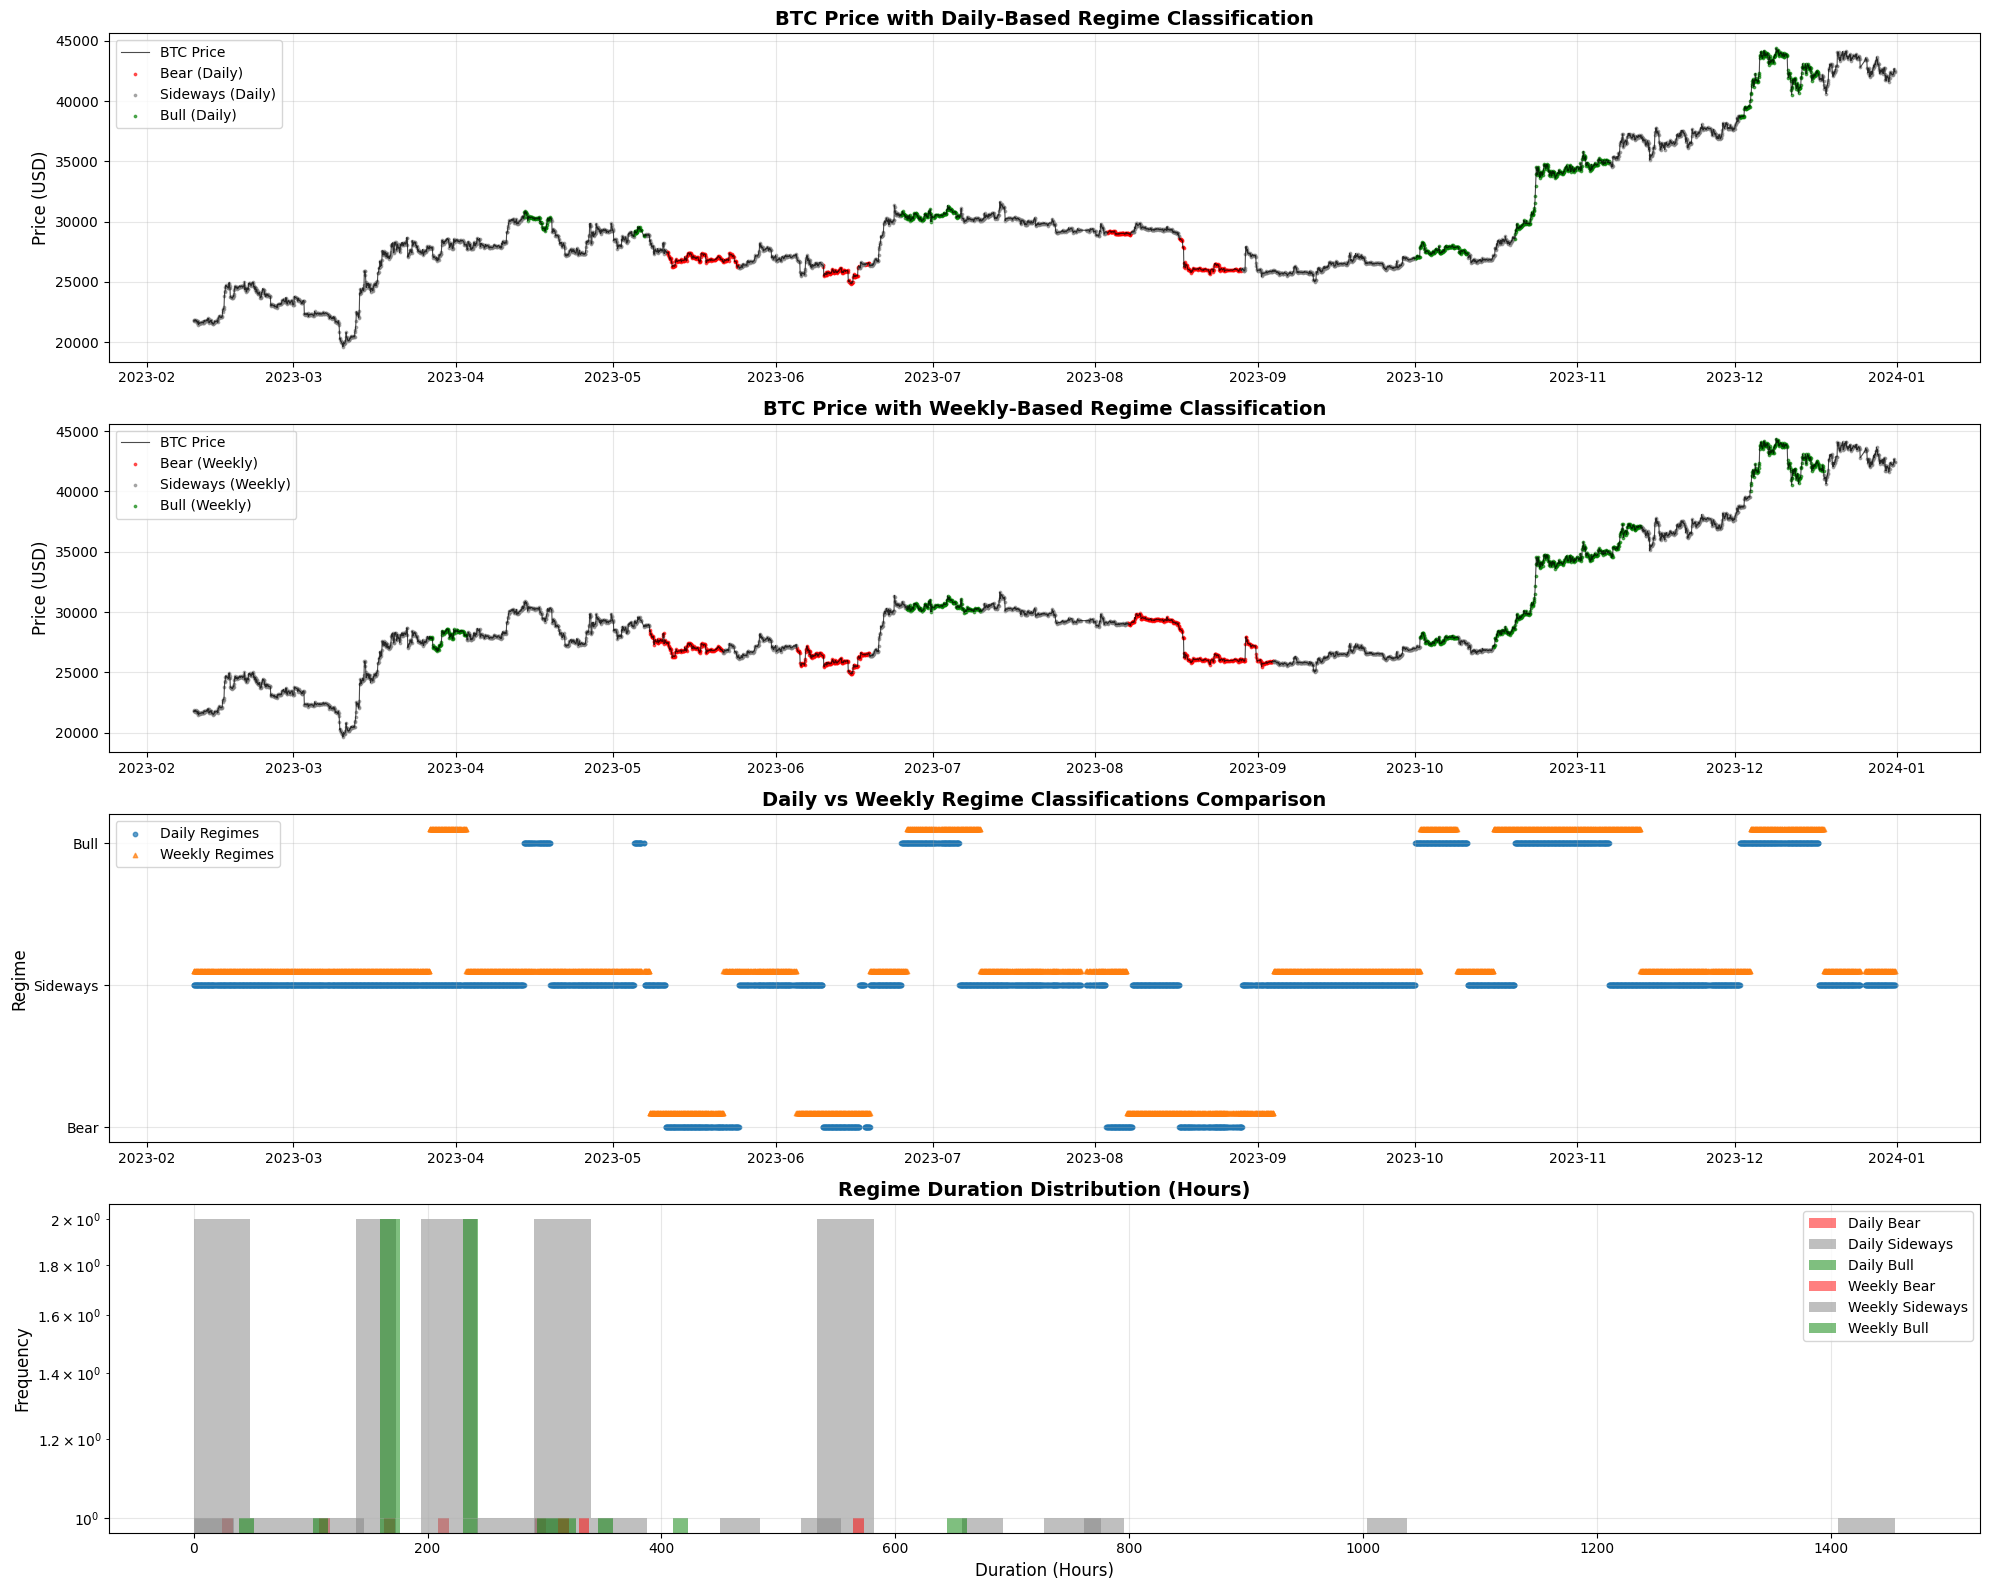


Regime Persistence Analysis:

Daily Method:
  Bear: Avg 163.9h, Max 301.4h, 5 periods
  Sideways: Avg 387.2h, Max 1454.9h, 13 periods
  Bull: Avg 231.2h, Max 422.3h, 6 periods

Weekly Method:
  Bear: Avg 405.3h, Max 573.0h, 3 periods
  Sideways: Avg 440.7h, Max 1038.0h, 10 periods
  Bull: Avg 323.6h, Max 661.2h, 5 periods


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(4, 1, figsize=(20, 16))

# Get sample data for visualization (every 100th point for clarity)
sample_interval = 100
sample_data = df_1min_hierarchical.iloc[::sample_interval]
regime_colors = {0: 'red', 1: 'gray', 2: 'green'}
regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}

# Plot 1: Price with daily regimes
ax1 = axes[0]
ax1.plot(sample_data.index, sample_data['Close'], linewidth=0.8, color='black', alpha=0.7, label='BTC Price')

# Color background by daily regime
for regime in [0, 1, 2]:
    regime_mask = sample_data['regime_daily'] == regime
    if regime_mask.any():
        ax1.scatter(sample_data.index[regime_mask], 
                   sample_data['Close'][regime_mask],
                   c=regime_colors[regime], alpha=0.6, s=3,
                   label=f'{regime_names[regime]} (Daily)')

ax1.set_title('BTC Price with Daily-Based Regime Classification', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price (USD)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Price with weekly regimes
ax2 = axes[1]
ax2.plot(sample_data.index, sample_data['Close'], linewidth=0.8, color='black', alpha=0.7, label='BTC Price')

# Color background by weekly regime
for regime in [0, 1, 2]:
    regime_mask = sample_data['regime_weekly'] == regime
    if regime_mask.any():
        ax2.scatter(sample_data.index[regime_mask], 
                   sample_data['Close'][regime_mask],
                   c=regime_colors[regime], alpha=0.6, s=3,
                   label=f'{regime_names[regime]} (Weekly)')

ax2.set_title('BTC Price with Weekly-Based Regime Classification', fontsize=14, fontweight='bold')
ax2.set_ylabel('Price (USD)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Daily vs Weekly regime comparison
ax3 = axes[2]

# Plot daily regimes
ax3.scatter(sample_data.index, sample_data['regime_daily'], 
           alpha=0.7, s=10, label='Daily Regimes', marker='o')

# Plot weekly regimes (offset slightly for visibility)
ax3.scatter(sample_data.index, sample_data['regime_weekly'] + 0.1, 
           alpha=0.7, s=10, label='Weekly Regimes', marker='^')

ax3.set_title('Daily vs Weekly Regime Classifications Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Regime', fontsize=12)
ax3.set_yticks([0, 1, 2])
ax3.set_yticklabels(['Bear', 'Sideways', 'Bull'])
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Regime persistence analysis
ax4 = axes[3]

# Calculate regime persistence (how long each regime lasts)
def calculate_regime_persistence(regime_series, name):
    changes = regime_series.diff() != 0
    regime_periods = []
    current_regime = regime_series.iloc[0]
    period_start = 0
    
    for i, is_change in enumerate(changes):
        if is_change or i == len(regime_series) - 1:
            period_length = i - period_start
            regime_periods.append({
                'regime': current_regime,
                'length': period_length,
                'method': name
            })
            current_regime = regime_series.iloc[i]
            period_start = i
    
    return pd.DataFrame(regime_periods)

# Calculate persistence for both methods
daily_persistence = calculate_regime_persistence(df_1min_hierarchical['regime_daily'].dropna(), 'Daily')
weekly_persistence = calculate_regime_persistence(df_1min_hierarchical['regime_weekly'].dropna(), 'Weekly')

# Plot regime duration distributions
for method, persistence_df in [('Daily', daily_persistence), ('Weekly', weekly_persistence)]:
    for regime in [0, 1, 2]:
        regime_data = persistence_df[persistence_df['regime'] == regime]['length']
        if len(regime_data) > 0:
            # Convert to hours for better readability
            regime_hours = regime_data / 60
            ax4.hist(regime_hours, bins=30, alpha=0.5, 
                    label=f'{method} {regime_names[regime]}', 
                    color=regime_colors[regime])

ax4.set_title('Regime Duration Distribution (Hours)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Duration (Hours)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

plt.tight_layout()
plt.show()

# Print persistence statistics
print("\nRegime Persistence Analysis:")
print("=" * 40)

for method, persistence_df in [('Daily', daily_persistence), ('Weekly', weekly_persistence)]:
    print(f"\n{method} Method:")
    for regime in [0, 1, 2]:
        regime_data = persistence_df[persistence_df['regime'] == regime]['length']
        if len(regime_data) > 0:
            avg_duration = regime_data.mean() / 60  # Convert to hours
            max_duration = regime_data.max() / 60
            periods = len(regime_data)
            print(f"  {regime_names[regime]}: Avg {avg_duration:.1f}h, Max {max_duration:.1f}h, {periods} periods")

## 6. Choose Final Regime Classification and Export

In [7]:
# Compare the two approaches and choose the best one
print("Comparing Hierarchical Approaches:")
print("=" * 50)

# Calculate average regime duration
daily_avg_duration = daily_persistence['length'].mean() / 60  # hours
weekly_avg_duration = weekly_persistence['length'].mean() / 60  # hours

print(f"\nDaily-based approach:")
print(f"  Average regime duration: {daily_avg_duration:.1f} hours")
print(f"  Total regime changes: {len(daily_persistence)}")
print(f"  Regime distribution balance: {daily_regime_counts.std():.1f} (lower is more balanced)")

print(f"\nWeekly-based approach:")
print(f"  Average regime duration: {weekly_avg_duration:.1f} hours")
print(f"  Total regime changes: {len(weekly_persistence)}")
print(f"  Regime distribution balance: {weekly_regime_counts.std():.1f} (lower is more balanced)")

# Choose approach based on criteria
# Prefer longer duration and fewer changes for more stable regimes
if weekly_avg_duration > daily_avg_duration and len(weekly_persistence) < len(daily_persistence):
    chosen_approach = 'weekly'
    chosen_regime_col = 'regime_weekly'
    print(f"\n✅ CHOSEN APPROACH: Weekly-based (more stable, longer duration)")
else:
    chosen_approach = 'daily'
    chosen_regime_col = 'regime_daily'
    print(f"\n✅ CHOSEN APPROACH: Daily-based (more responsive)")

# Create final dataset with chosen regime classification
df_final = df_1min_hierarchical.copy()
df_final['regime'] = df_final[chosen_regime_col]

# Add both for comparison
df_final = df_final.rename(columns={
    'regime_daily': 'regime_daily_method',
    'regime_weekly': 'regime_weekly_method'
})

# Final regime distribution
final_regime_counts = df_final['regime'].value_counts().sort_index()
print(f"\nFinal Regime Distribution ({chosen_approach}-based):")
for regime, count in final_regime_counts.items():
    pct = count / len(df_final) * 100
    print(f"  {regime_names[regime]} ({regime}): {count:,} ({pct:.1f}%)")

# Export the final classified dataset
output_path = f'../data/BTCUSD_2023_1min_hierarchical_regimes_{chosen_approach}.csv'
df_final.to_csv(output_path)

print(f"\n💾 Exported final dataset to: {output_path}")
print(f"📊 Dataset shape: {df_final.shape}")
print(f"🏷️  Regime column: '{chosen_regime_col}' -> 'regime'")

# Create metadata
import json

metadata = {
    'method': 'hierarchical',
    'approach': chosen_approach,
    'classification_timeframe': f'{chosen_approach}_bars',
    'applied_to': '1min_bars',
    'description': f'Regime classification based on {chosen_approach} timeframe, applied to all 1-minute bars within each {chosen_approach[:-2]} period',
    'regime_distribution': {
        'Bear (0)': f"{final_regime_counts.get(0, 0):,} ({final_regime_counts.get(0, 0)/len(df_final)*100:.1f}%)",
        'Sideways (1)': f"{final_regime_counts.get(1, 0):,} ({final_regime_counts.get(1, 0)/len(df_final)*100:.1f}%)",
        'Bull (2)': f"{final_regime_counts.get(2, 0):,} ({final_regime_counts.get(2, 0)/len(df_final)*100:.1f}%)"
    },
    'average_regime_duration_hours': weekly_avg_duration if chosen_approach == 'weekly' else daily_avg_duration,
    'total_regime_changes': len(weekly_persistence) if chosen_approach == 'weekly' else len(daily_persistence),
    'data_range': f"{df_final.index.min()} to {df_final.index.max()}",
    'created_at': datetime.now().isoformat()
}

metadata_path = f'../data/hierarchical_regime_classification_{chosen_approach}_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"📋 Saved metadata to: {metadata_path}")

print("\n" + "=" * 60)
print("HIERARCHICAL REGIME CLASSIFICATION COMPLETE")
print("=" * 60)
print("✅ Regime classification based on longer timeframes")
print("✅ Applied to all 1-minute data within each period")
print("✅ More stable regime transitions")
print("✅ All 3 regime classes present")
print("✅ Ready for ML model training")
print("\n🎯 Key Advantage: Regimes now represent longer-term market conditions")
print("   rather than minute-by-minute noise, making them more realistic")
print("   for actual trading strategy implementation.")
print("=" * 60)

Comparing Hierarchical Approaches:

Daily-based approach:
  Average regime duration: 301.7 hours
  Total regime changes: 24
  Regime distribution balance: 137221.2 (lower is more balanced)

Weekly-based approach:
  Average regime duration: 402.3 hours
  Total regime changes: 18
  Regime distribution balance: 104268.5 (lower is more balanced)

✅ CHOSEN APPROACH: Weekly-based (more stable, longer duration)

Final Regime Distribution (weekly-based):
  Bear (0): 72,947 (16.8%)
  Sideways (1): 264,402 (60.9%)
  Bull (2): 97,089 (22.3%)

💾 Exported final dataset to: ../data/BTCUSD_2023_1min_hierarchical_regimes_weekly.csv
📊 Dataset shape: (434438, 28)
🏷️  Regime column: 'regime_weekly' -> 'regime'
📋 Saved metadata to: ../data/hierarchical_regime_classification_weekly_metadata.json

HIERARCHICAL REGIME CLASSIFICATION COMPLETE
✅ Regime classification based on longer timeframes
✅ Applied to all 1-minute data within each period
✅ More stable regime transitions
✅ All 3 regime classes present
✅ Re